In [35]:
library(tidyverse)
library(data.table)
library(glue)
library(ComplexHeatmap)


Loading required package: grid

ComplexHeatmap version 2.16.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




# Intro

The goal is to compute the correlations between sQTL beta and eQTL beta for top p vs. u sQTL top SNPs in a heatmap. It effectively summarises the 49 beta vs. beta scatter plots.

data:

1. p vs. u sQTL top SNPs
2. regression slope in sQTL mapping
3. regression slope in eQTL mapping

do this for each of the 49 tissues. Result is a 2x49 matrix where

- row labels: u or p sQTL (2)
- col labels: tissue (49)
- values: correlation value of betas.

plot heatmap:

- split heatmap into 5 sub heatmaps, each is 2x10 (9) matrix


In [32]:
grab_corr_matrix <- function(rds_file) {
  data <- readRDS(rds_file)
  corrDF <- data$corrDF
  return(corrDF)
}


In [27]:
rds_files <- list.files("/project/yangili1/cdai/splice-pub/smk-plots/gtex-sqtl-enrichment-v4", pattern = "*.rds", full.names = TRUE)


In [30]:
rds_files[1:5]


Adipose-Subcutaneous 
     "/project/yangili1/cdai/splice-pub/smk-plots/gtex-sqtl-enrichment-v4/Adipose-Subcutaneous.rds" 
                                                                          Adipose-Visceral_Omentum_ 
"/project/yangili1/cdai/splice-pub/smk-plots/gtex-sqtl-enrichment-v4/Adipose-Visceral_Omentum_.rds" 
                                                                                       AdrenalGland 
             "/project/yangili1/cdai/splice-pub/smk-plots/gtex-sqtl-enrichment-v4/AdrenalGland.rds" 
                                                                                       Artery-Aorta 
             "/project/yangili1/cdai/splice-pub/smk-plots/gtex-sqtl-enrichment-v4/Artery-Aorta.rds" 
                                                                                    Artery-Coronary 
          "/project/yangili1/cdai/splice-pub/smk-plots/gtex-sqtl-enrichment-v4/Artery-Coronary.rds"

In [29]:
names(rds_files) <- rds_files %>%
  str_split("/") %>%
  map(pluck, 8) %>%
  unlist() %>%
  str_remove("\\.rds")


In [33]:
corrDFs <- map(rds_files, grab_corr_matrix)


In [34]:
corrDFs[1:3]


,ctype,pval,estimate,xpos,ypos
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
UP,Unproductive,3.436802e-19,-0.1941038,0,0
PR,Productive,1.422365e-14,-0.1189931,0,0
,ctype,pval,estimate,xpos,ypos
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
UP,Unproductive,8.988684e-16,-0.1908855,0,0
PR,Productive,4.018209e-10,-0.1062009,0,0
,ctype,pval,estimate,xpos,ypos
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
UP,Unproductive,7.280542e-12,-0.22323042,0,0


In [41]:
corrDFs[1:3]


,ctype,pval,estimate,xpos,ypos
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
UP,Unproductive,3.436802e-19,-0.1941038,0,0
PR,Productive,1.422365e-14,-0.1189931,0,0
,ctype,pval,estimate,xpos,ypos
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
UP,Unproductive,8.988684e-16,-0.1908855,0,0
PR,Productive,4.018209e-10,-0.1062009,0,0
,ctype,pval,estimate,xpos,ypos
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
UP,Unproductive,7.280542e-12,-0.22323042,0,0


In [56]:
df <- corrDFs %>%
  map(select, estimate) %>%
  map(rownames_to_column, "type") %>%
  map(arrange, "type") %>%
  map(column_to_rownames, "type") %>%
  do.call(cbind, .)
colnames(df) <- names(rds_files)


In [78]:
# modified estimate based on p-value
df2 <- corrDFs %>%
  map(~ mutate(.x, estimate = if_else(pval < 0.01, estimate, 0))) %>%
  map(select, estimate) %>%
  map(rownames_to_column, "type") %>%
  map(arrange, "type") %>%
  map(column_to_rownames, "type") %>%
  do.call(cbind, .)
colnames(df2) <- names(rds_files)


In [57]:
df


,Adipose-Subcutaneous,Adipose-Visceral_Omentum_,AdrenalGland,Artery-Aorta,Artery-Coronary,Artery-Tibial,Brain-Amygdala,Brain-Anteriorcingulatecortex_BA24_,Brain-Caudate_basalganglia_,Brain-CerebellarHemisphere,⋯,Skin-NotSunExposed_Suprapubic_,Skin-SunExposed_Lowerleg_,SmallIntestine-TerminalIleum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,WholeBlood
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UP,-0.1941038,-0.1908855,-0.22323042,-0.21017441,-0.2038709,-0.19757878,-0.01900822,-0.08316183,-0.05905698,-0.05045548,⋯,-0.195771,-0.177554,-0.11428881,-0.06517007,-0.19055798,-0.13326907,-0.1145808,-0.0887385,-0.06929688,-0.2246843
PR,-0.1189931,-0.1062009,-0.06223748,-0.05800334,-0.0626187,-0.08031865,-0.19738127,-0.11366195,-0.19284389,-0.07773858,⋯,-0.130075,-0.110294,-0.06190784,-0.09854179,-0.04542859,-0.06610528,-0.1057554,-0.1011198,-0.14068113,-0.1897486


In [138]:
columnOrder <- df["UP", ] %>%
  t() %>%
  as.data.frame() %>%
  rownames_to_column("tissue") %>%
  mutate(order = rank(UP, ties.method = "first")) %>%
  arrange(order) %>%
  pull(tissue)


In [140]:
columnOrder


[1] "Cells-Culturedfibroblasts"           
 [2] "Cells-EBV-transformedlymphocytes"    
 [3] "Muscle-Skeletal"                     
 [4] "Heart-LeftVentricle"                 
 [5] "Esophagus-Mucosa"                    
 [6] "WholeBlood"                          
 [7] "AdrenalGland"                        
 [8] "Heart-AtrialAppendage"               
 [9] "Artery-Aorta"                        
[10] "Pancreas"                            
[11] "Artery-Coronary"                     
[12] "MinorSalivaryGland"                  
[13] "Artery-Tibial"                       
[14] "Skin-NotSunExposed_Suprapubic_"      
[15] "Adipose-Subcutaneous"                
[16] "Adipose-Visceral_Omentum_"           
[17] "Stomach"                             
[18] "Colon-Transverse"                    
[19] "Esophagus-Muscularis"                
[20] "Skin-SunExposed_Lowerleg_"           
[21] "Esophagus-GastroesophagealJunction"  
[22] "Breast-MammaryTissue"                
[23] "Lung"                                
[24] "Brain-FrontalCortex_BA9_"            
[25] "Testis"                              
[26] "Colon-Sigmoid"                       
[27] "Brain-Nucleusaccumbens_basalganglia_"
[28] "Thyroid"                             
[29] "SmallIntestine-TerminalIleum"        
[30] "Nerve-Tibial"                        
[31] "Brain-Cerebellum"                    
[32] "Uterus"                              
[33] "Brain-Anteriorcingulatecortex_BA24_" 
[34] "Prostate"                            
[35] "Brain-Cortex"                        
[36] "Vagina"                              
[37] "Liver"                               
[38] "Spleen"                              
[39] "Brain-Hippocampus"                   
[40] "Ovary"                               
[41] "Brain-Caudate_basalganglia_"         
[42] "Brain-CerebellarHemisphere"          
[43] "Pituitary"                           
[44] "Brain-Putamen_basalganglia_"         
[45] "Brain-Substantianigra"               
[46] "Brain-Amygdala"                      
[47] "Brain-Hypothalamus"                  
[48] "Brain-Spinalcord_cervicalc-1_"       
[49] "Kidney-Cortex"

In [71]:
legendBreaks <- c(-.3, -.2, -.1, 0, 0.1)
colors <- c("#085193", "#4292c6", "#c6d8ef", "#ffffff", "#fc8d59")
colfunc <- circlize::colorRamp2(
  breaks = legendBreaks,
  colors = colors
)


In [90]:
legendBreaks <- c(-.3, -.2, -.1, -0.0001, -0.00001, 0, 0.00001, 0.0001, 0.1)
colors <- c("#085193", "#4292c6", "#c6d8ef", "white", "white", "grey", "white", "white", "#fc8d59")
colfunc <- circlize::colorRamp2(
  breaks = legendBreaks,
  colors = colors
)


In [137]:
df2 %>%
  as.matrix() %>%
  head()


,Adipose-Subcutaneous,Adipose-Visceral_Omentum_,AdrenalGland,Artery-Aorta,Artery-Coronary,Artery-Tibial,Brain-Amygdala,Brain-Anteriorcingulatecortex_BA24_,Brain-Caudate_basalganglia_,Brain-CerebellarHemisphere,⋯,Skin-NotSunExposed_Suprapubic_,Skin-SunExposed_Lowerleg_,SmallIntestine-TerminalIleum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,WholeBlood
UP,-0.1941038,-0.1908855,-0.22323042,-0.21017441,-0.2038709,-0.19757878,0.0000000,-0.08316183,0.0000000,0.00000000,⋯,-0.195771,-0.177554,-0.1142888,0.00000000,-0.190558,-0.13326907,-0.1145808,0.0000000,0.0000000,-0.2246843
PR,-0.1189931,-0.1062009,-0.06223748,-0.05800334,-0.0626187,-0.08031865,-0.1973813,0.00000000,-0.1928439,-0.07773858,⋯,-0.130075,-0.110294,0.0000000,-0.09854179,0.000000,-0.06610528,-0.1057554,-0.1011198,-0.1406811,-0.1897486


In [163]:
gtex_tissue_code <- fread("/project/yangili1/cdai/splice-pub/analysis/gtex-tissue-code.csv", col.names = c("tissue", "code"), header = F)
dim(gtex_tissue_code)
gtex_tissue_code[1:2]


[1] 49  2

tissue,code
<chr>,<chr>
Adipose-Subcutaneous,ADPSBO
Adipose-Visceral_Omentum_,ADPVSC


In [181]:
options(repr.plot.width = 20, repr.plot.height = 3, repr.plot.res = 300)


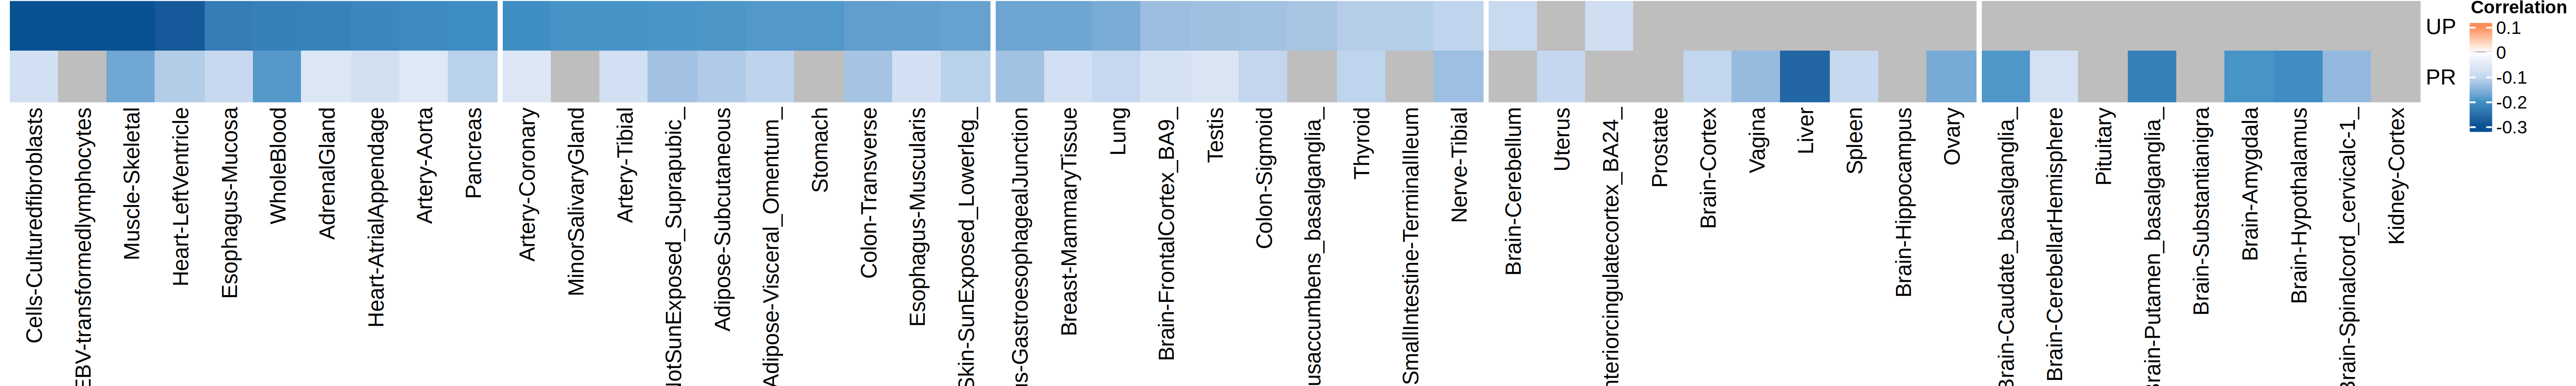

In [190]:
set.seed(123)
cluster_method <- "ward.D"
df2[, columnOrder] %>%
  as.matrix() %>%
  Heatmap(
    col = colfunc,
    show_parent_dend_line = FALSE,
    use_raster = TRUE,
    cluster_columns = FALSE, cluster_rows = F,
    column_split = c(rep("G1", 10), rep("G2", 10), rep("G3", 10), rep("G4", 10), rep("G5", 9)),
    height = unit(2, "cm"),
    heatmap_legend_param = list(title = "Correlation")
  )


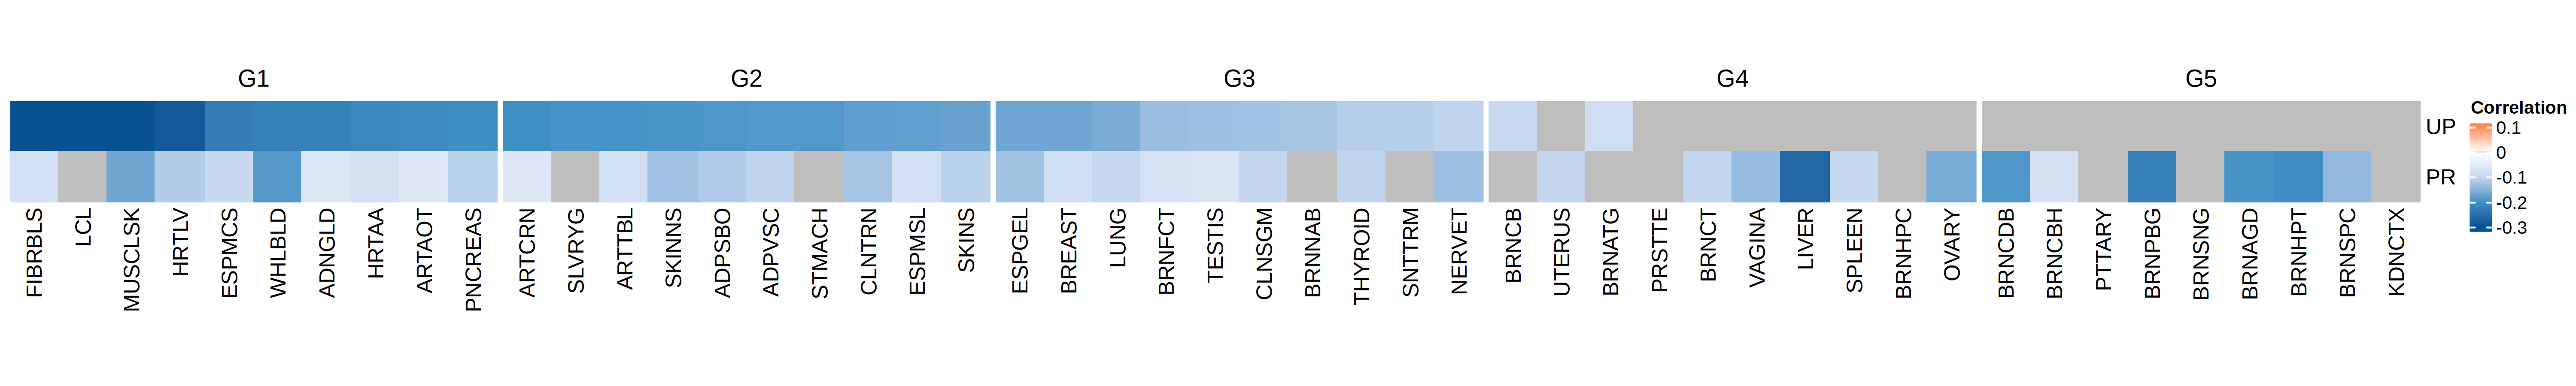

In [189]:
set.seed(123)
cluster_method <- "ward.D"
df2[, columnOrder] %>%
  as.matrix() %>%
  Heatmap(
    col = colfunc,
    show_parent_dend_line = FALSE,
    use_raster = TRUE,
    cluster_columns = FALSE, cluster_rows = F,
    column_split = c(rep("G1", 10), rep("G2", 10), rep("G3", 10), rep("G4", 10), rep("G5", 9)),
    column_labels = column_to_rownames(gtex_tissue_code, "tissue") %>% .[colnames(df2[, columnOrder]),],
    height = unit(2, "cm"),
    heatmap_legend_param = list(title = "Correlation")
  )


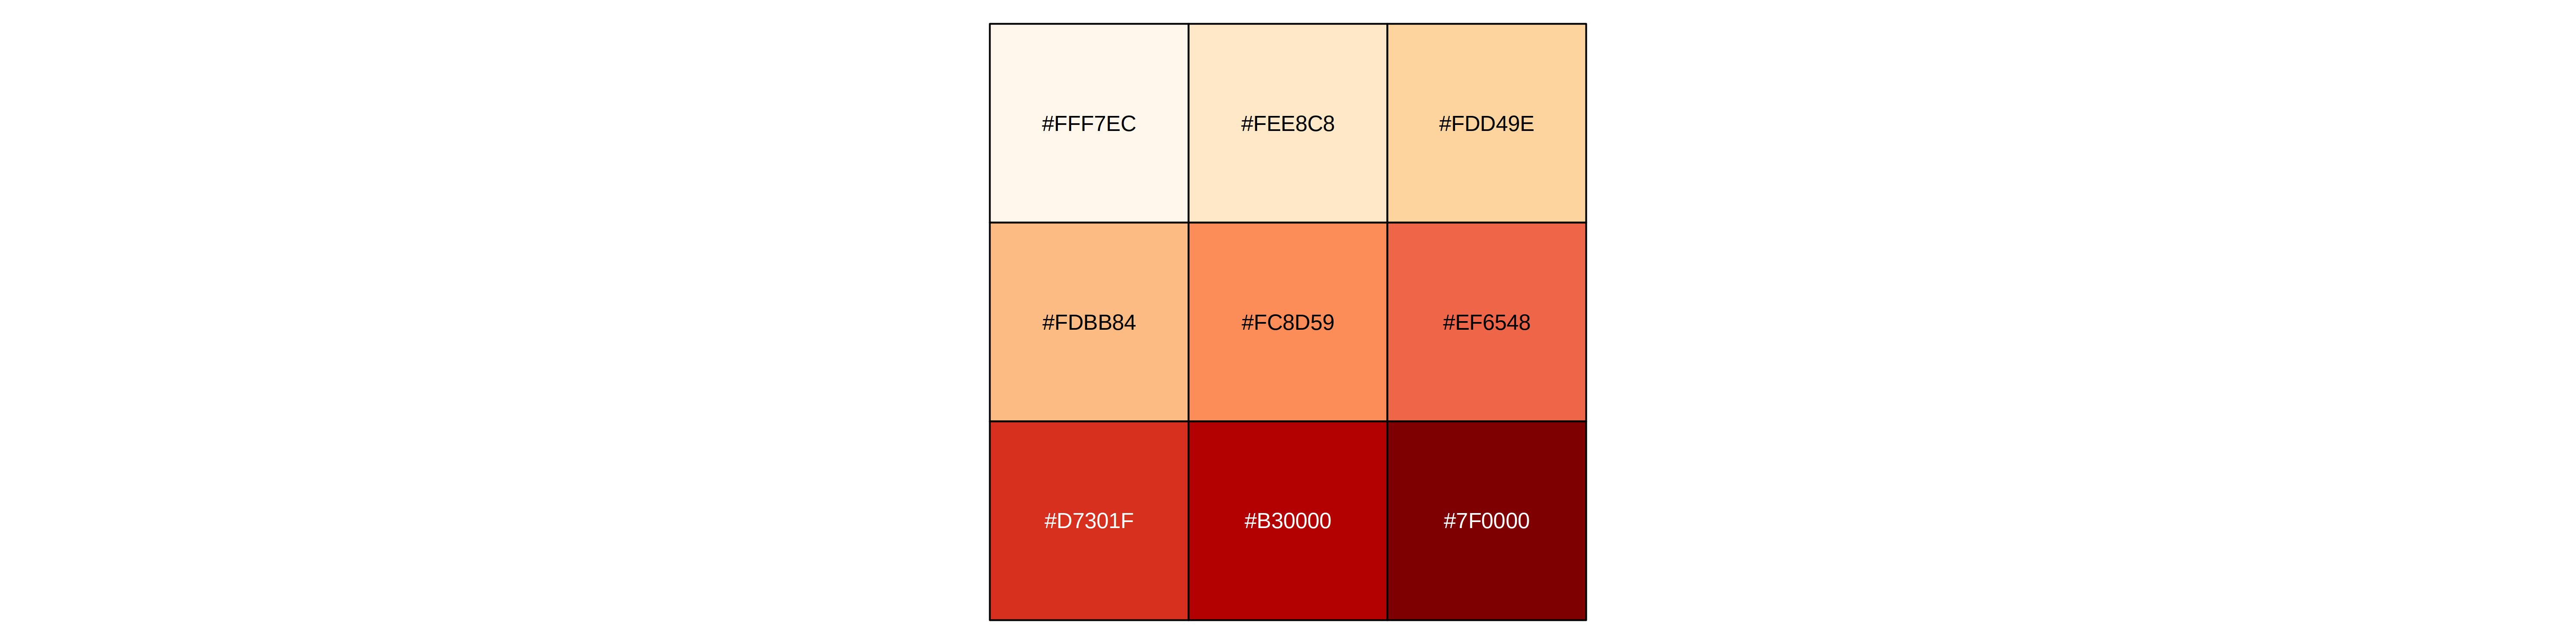

In [70]:
# get hex color codes for the Blues palette in Rcolorbrewer:

hexcode <- RColorBrewer::brewer.pal(9, "OrRd")

# display the hex color codes
scales::show_col(hexcode)


In [98]:
?Heatmap


Heatmap             package:ComplexHeatmap             R Documentation

_C_o_n_s_t_r_u_c_t_o_r _m_e_t_h_o_d _f_o_r _H_e_a_t_m_a_p _c_l_a_s_s

_D_e_s_c_r_i_p_t_i_o_n:

     Constructor method for Heatmap class

_U_s_a_g_e:

     Heatmap(matrix, col, name,
         na_col = "grey",
         color_space = "LAB",
         rect_gp = gpar(col = NA),
         border = NA,
         border_gp = gpar(col = "black"),
         cell_fun = NULL,
         layer_fun = NULL,
         jitter = FALSE,
         
         row_title = character(0),
         row_title_side = c("left", "right"),
         row_title_gp = gpar(fontsize = 13.2),
         row_title_rot = switch(row_title_side[1], "left" = 90, "right" = 270),
         column_title = character(0),
         column_title_side = c("top", "bottom"),
         column_title_gp = gpar(fontsize = 13.2),
         column_title_rot = 0,
         
         cluster_rows = TRUE,
         cluster_row_slices = TRUE,
  